In [1]:
import numpy as np
from scipy.special import hankel1
from scipy.integrate import quad, dblquad
import matplotlib.pyplot as plt
import torch
import sys

In [2]:
sys.path.append('..')

In [3]:
from src.lippmann_schwinger_eqn.solver_utils import (greensfunction2, greensfunction3, find_diag_correction)
from src.lippmann_schwinger_eqn.HelmholtzSolver import setup_accelerated_solver, setup_dense_solver

# Check Correction for the Singularity in the Green's Function

We want to use a regular grid to discretize our Green's function, but the Green's function has a singularity at $x=0$ and the regular grid has a grid point at $x=0$. 

The function `setup_accelerated_solver()` has an option `diag_correction`. If set to True, the setup will involve computing a correction for the singularity, which will be inserted at $x=0$. Otherwise, we will replace the singularity with 0. 

This notebook is meant to test the accuracy of that correction. We define a test function $f(x)$, which is a rapidly-decaying Gaussian. To evaluate the accuracy of the correction, we want to compute the expression

$$ \int_{x=-1/2}^{1/2} f(x) G(x) dx = (f \star G)(0) $$

We compute the expression multiple different ways:
 * `G_apply` which uses the computed correction for the singularity.
 * `G_apply` without the correction for the singularity.
 * Adaptive integration using `scipy`. We treat this as the ground-truth value of the above integral.

# Set up things for fast G apply

In [4]:
N_PIXELS = 50
SPATIAL_DOMAIN_MAX = 0.5
WAVENUMBER = 5
RECEIVER_RADIUS = 100

In [5]:
frequency = 2 * np.pi * WAVENUMBER
source_receiver_directions = np.linspace(0, 2 * np.pi, N_PIXELS + 1)[:N_PIXELS]

x = np.linspace(
    -SPATIAL_DOMAIN_MAX, SPATIAL_DOMAIN_MAX, num=N_PIXELS, endpoint=False
)
h = x[1] - x[0]


# Define utility functions

In [6]:
def _gaussian(rad: np.ndarray, sigma: float) -> np.ndarray:
    return np.exp(-1 * np.square(rad) / (sigma**2))


# Define a grid and do the analytic integral

In [7]:
SIGMA_VAL =  0.1
print(SIGMA_VAL)

def _int_eval_func(r: float) -> float:
    abs_r = np.abs(r)
    f = _gaussian(abs_r, SIGMA_VAL)
    g = -1j / 4 * hankel1(0, frequency * abs_r)
    return (f * g) * abs_r  * np.pi * 2

adaptive_int_val, _ = quad(
    _int_eval_func, 0, 0.5, complex_func=True, points=(0,)
)


0.1


In [8]:
print(adaptive_int_val)

(0.0014663734926861406-0.0006660566962761515j)


In [9]:
grid_points = np.linspace(-.5, .5, 200, endpoint=False)

In [10]:
f_evals = (_gaussian(grid_points, SIGMA_VAL))
g_evals = -1j / 4 * hankel1(0, frequency * np.abs(grid_points))

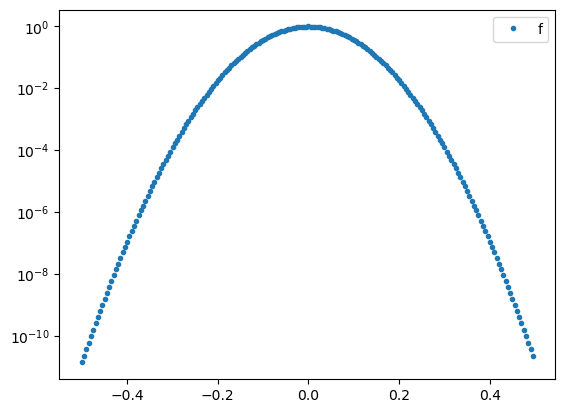

<Figure size 640x480 with 0 Axes>

In [25]:
plt.plot(grid_points, f_evals, '.', label='f')
# plt.plot(grid_points, np.abs(g_evals), '.', label='G')
# plt.plot(grid_points, np.abs(f_evals * g_evals * np.abs(grid_points)), '.', label='FGr')
plt.yscale('log')
plt.legend()
plt.show()
plt.clf()

# Do the integration with quadrature on increasingly fine grids

In [12]:
N_PIXELS_ARRAY = np.array([20, 50, 100, 192])

In [13]:
solver_obj_lst = []
for x in N_PIXELS_ARRAY:
    print("Working on N_PIXELS = ", x)
    solver_obj_lst.append(setup_accelerated_solver(x, 
                                           SPATIAL_DOMAIN_MAX, 
                                           WAVENUMBER, 
                                           RECEIVER_RADIUS, 
                                           diag_correction=False))

Working on N_PIXELS =  20
Working on N_PIXELS =  50
Working on N_PIXELS =  100
Working on N_PIXELS =  192


In [14]:
val_lst = []
err_lst_no_diag_correction = []
for i, solver_obj in enumerate(solver_obj_lst):
    nrms = np.linalg.norm(solver_obj.domain_points_arr, axis=-1)
    bool_arr = nrms < 0.5
    bin_arr = bool_arr.astype(np.float32)
    scattering_obj = _gaussian(nrms, SIGMA_VAL) * bin_arr
    
    zero_idx = np.argwhere(nrms == 0)[0, 0]
    
    s = torch.from_numpy(scattering_obj.flatten()).unsqueeze(-1)
    out_mat = solver_obj._G_apply(s).cpu().numpy().reshape(scattering_obj.shape)
    out_val = out_mat[zero_idx, zero_idx]

    val = out_val
    err = np.abs(val - adaptive_int_val) / np.abs(adaptive_int_val)
    val_lst.append(val)
    err_lst_no_diag_correction.append(err)
    print(f"N_pixels: {solver_obj.N}, err: {err}, val: {val}")

N_pixels: 20, err: 0.44486298051148354, val: (0.0018166767363666703-4.105669693477692e-05j)
N_pixels: 50, err: 0.09676122421969192, val: (0.0015858968605999212-0.0005660566962809027j)
N_pixels: 100, err: 0.029857112822518423, val: (0.0015074503654021023-0.0006410566962776071j)
N_pixels: 192, err: 0.009641955667138357, val: (0.0014803432836806955-0.0006592750122489151j)


In [15]:
solver_obj_lst = []
for x in N_PIXELS_ARRAY:
    print("Working on N_PIXELS = ", x)
    solver_obj_lst.append(setup_accelerated_solver(x, 
                                           SPATIAL_DOMAIN_MAX, 
                                           WAVENUMBER, 
                                           RECEIVER_RADIUS, 
                                           diag_correction=True))

Working on N_PIXELS =  20
Working on N_PIXELS =  50
Working on N_PIXELS =  100
Working on N_PIXELS =  192


In [16]:
val_lst = []
err_lst = []
for i, solver_obj in enumerate(solver_obj_lst):
    nrms = np.linalg.norm(solver_obj.domain_points_arr, axis=-1)
    bool_arr = nrms < 0.5
    bin_arr = bool_arr.astype(np.float32)
    scattering_obj = _gaussian(nrms, SIGMA_VAL) * bin_arr
    
    zero_idx = np.argwhere(nrms == 0)[0, 0]
    
    s = scattering_obj.flatten()
    s_torch = torch.from_numpy(s).unsqueeze(-1)
    
    out_mat = solver_obj._G_apply(s_torch).cpu().numpy().reshape(scattering_obj.shape)
    out_val = out_mat[zero_idx, zero_idx]

    val = out_val
    err = np.abs(val - adaptive_int_val) / np.abs(adaptive_int_val)
    val_lst.append(val)
    err_lst.append(err)
    print(f"N_pixels: {solver_obj.N}, err: {err}, val: {val}")

N_pixels: 20, err: 0.007655182185611077, val: (0.0014540444118286376-0.0006660566969347442j)
N_pixels: 50, err: 0.00015709708056510044, val: (0.0014661204794250838-0.0006660566962808985j)
N_pixels: 100, err: 9.542816554639163e-06, val: (0.0014663581234690458-0.0006660566962776059j)
N_pixels: 192, err: 6.974415166953e-07, val: (0.0014663723694192288-0.000666056696276691j)


# Plot

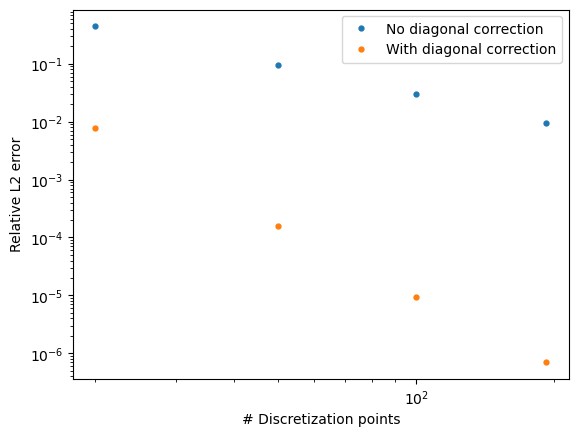

In [17]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
SIZE = 7

ax.plot(N_PIXELS_ARRAY, 
        err_lst_no_diag_correction, 
        '.', 
        markersize=SIZE, 
        label='No diagonal correction')

ax.plot(N_PIXELS_ARRAY, err_lst, '.', markersize=SIZE, label='With diagonal correction')
ax.set_xlabel('# Discretization points')
ax.set_ylabel('Relative L2 error')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

# Compute slopes in log-log space

In [18]:
log_n = np.log10(N_PIXELS_ARRAY)
log_err = np.log10(err_lst)
log_err_no_diag = np.log10(err_lst_no_diag_correction)

In [19]:
m, b = np.polyfit(log_n, log_err, 1)

In [20]:
b

3.212199641696425

In [21]:
m_no, b_no = np.polyfit(log_n, log_err_no_diag, 1)

In [22]:
print(m)
print(m_no)

-4.111527123454781
-1.6930701626682367


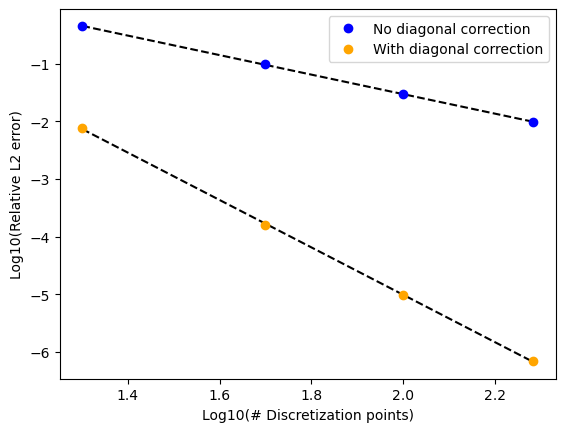

In [24]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
SIZE = 12

xvals = np.linspace(log_n[0], log_n[-1], 100)

ax.plot(xvals, m_no * xvals + b_no, '--', color='black')
ax.plot(xvals, m * xvals + b, '--', color='black')

ax.plot(log_n, log_err_no_diag, '.', color='blue', markersize=SIZE, label='No diagonal correction')
ax.plot(log_n, log_err, '.', color='orange', markersize=SIZE, label='With diagonal correction')
ax.set_xlabel('Log10(# Discretization points)')
ax.set_ylabel('Log10(Relative L2 error)')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend()
plt.show()